# Literature Sources for the Equations

[WSL Swiss Federal Institute for Forest, Snow, and Landscape Research Fire Weather Indices Wiki](https://wikifire.wsl.ch/tiki-index908f.html?page=Keetch-Byram+drought+index#:~:text=Formula,Keetch%20and%20Byram%20(1968).)

[Alexander, 1990: Computer calculation of the Keetch-Byram drought index - programmers beware](https://people.atmos.ucla.edu/ycao/papers/Computer%20Calculation%20of%20the%20Keetch-Byram%20Drought%20Index-Programmers%20Beware!.pdf)

[Keetch and Byram, 1968: A drought index for forest fire control, USDA FSRP SE-38](https://research.fs.usda.gov/treesearch/40)

[Wildland Fire Assessment System](https://www.wfas.net/index.php?option=com_content&view=article&id=86&Itemid=487#:~:text=Keetch%20and%20Byram%20(1968)%20designed,duff%20and%20upper%20soil%20layers.)

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

import dask
import dask.array as da

import matplotlib.pyplot as plt

In [ ]:
# file paths
pr_file = r'D://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
tmax_file = r'D://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'

# pr_file = r'E://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
# tmax_file = r'E://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'

In [ ]:
# parallelization
chunks = {'time':-1,'lat':100,'lon':100}

# Steps (starting with single cell calculation)

1) KBDI initialization: find the starting day of the calculation
    - find when the running sum of precip over a 1 week period is at least 152mm (6 inches)
    - the starting day for calculating KBDI is the next day
2) calculate the number of consecutive days with rain (rr) for the whole timeseries so we can accurately calculate Pnet
3) calculate Pnet at each time using the description in Keetch and Byram
4) calculate Q of t0 using KBDI of t-1 = 0
5) calculate KBDI

# 1) KBDI Initialization date

Finding the first possible day at each grid where we can set the initial value of KBDI to zero. This requires a preceding wet period where at least 152mm/6inches of precip falls with 1 week.

In [ ]:
# lazy load precip data in chunks, limit precision per metadata, and convert units

year_start='1951'
year_end='1960'
# lat = 32
# lon = -90

# pr=xr.open_dataset(pr_file).prcp.sel(time=slice(year_start,year_end)).sel(lat=lat,lon=lon, method='nearest').round(2).load()
pr=xr.open_dataset(pr_file, chunks=chunks)#.prcp.sel(time=slice(year_start,year_end)).round(2)

# pr = pr / 25.4
# pr_attrs = {'standard_name':'precipitation','long_name':'Precipitation, daily total','units':'inches/day'}
# pr.attrs = pr_attrs

pr

In [ ]:
def prep_pr_gufunc(p,year_start,year_end,decimals):
    p=p.sel(time=slice(year_start,year_end)).round(decimals)
    
    p = p / 25.4
    p_attrs = {'standard_name':'precipitation','long_name':'Precipitation, daily total','units':'inches/day'}
    p.attrs = p_attrs
    return p

def prep_pr(x, y, dim):
    return xr.apply_ufunc(
        prep_pr_gufunc,
        x,
        y,
        input_core_dims=[[dim], [dim]],
        dask="parallelized",
        output_dtypes=[float],
    )

In [ ]:
test=prep_pr(pr,'1951','1960',2).compute()
test

In [ ]:
# determine if the grid is land or water
landmask= xr.where(np.isfinite(pr.mean('time')),1,0)
landmask

In [ ]:
# # check that it worked
# landmask.plot()

In [ ]:
# create an integer time index coordinate since datetimes will give us some trouble

time_index=np.arange(0,len(pr.time)).astype('int')
pr.coords['time_index']=('time',time_index)

pr

In [ ]:
# sum precip in 7 day rolling windows

ndays=7
pr_thresh=np.float32(8) # inches

pr_weeksum=pr.rolling(time=ndays,min_periods=ndays,center=False).sum('time')
# print(pr_weeksum[0:10].data)
pr_weeksum

In [ ]:
# # when is the first 7 day sum over the threshold
# print(pr_weeksum[pr_weeksum>pr_thresh].isel(time=0).time.data)

# # what is the max 7 day sum
# print(pr_weeksum.max('time').item())

# # how many times does the 7 day sum exceed 8
# print((pr_weeksum>8).data.sum())

In [ ]:
# get the first index time where the weekly sum meets the threshold
# this is index t-1 for the KBDI calc where we'll set it to 0

# day_index = xr.where(pr_weeksum>pr_thresh,pr_weeksum.time_index,np.nan).min('time')
# day_int = pr_weeksum[pr_weeksum>pr_thresh].isel(time=0).time_index.item()
# day_int
day_int = xr.where(pr_weeksum>pr_thresh,pr_weeksum.time_index,np.nan)#.min('time_index')
day_int

# 2) rr, number of consecutive days with rain

In [ ]:
# 1/0 rain/no rain mask
rainmask=xr.where(pr>0,1,0)
rainmask

In [ ]:
# calculate number of consecutive rain days at each time step
# I got this code to interrupt a cumulative sum here: https://stackoverflow.com/questions/61753567/convert-cumsum-output-to-binary-array-in-xarray

rr=rainmask.cumsum()-rainmask.cumsum().where(rainmask == 0).ffill(dim='time').fillna(0)
rr

In [ ]:
# let's see if it's really working
fig=plt.figure(figsize=(15,2))
plt.axhline(y=0,color='grey',ls='dashed')  # threshold guide line
plt.ylim([-.25,4.25])
# pr.sel(time=slice('1951-01-01','1951-01-31')).plot()
# rr.sel(time=slice('1951-01-01','1951-01-31')).plot(marker='o',linewidth=0)
pr.sel(time=slice('2024-01-01','2024-01-31')).plot()
rr.sel(time=slice('2024-01-01','2024-01-31')).plot(marker='o',linewidth=0)

wow, ok it is working. blue line is daily precip, orange dots are the number of consecutive rain days.


# 3) Pnet

Approach based on Keetch & Byram 1968 description of Pnet calculation on their worksheet:

1) Categorize days: consecutive rain days (2), single rain days (1), no rain days (0)
2) Calculate Pnet on each day based on the category
    - category 0 (no rain): pnet = 0
    - category 1 (single rain day): pnet = max(pr - 0.2,0)  
    - category 2 (consecutive rain day): loop through events of consecutive rainfall days and
      
            - accumulate rainfall totals over consecutive days
            - on days before threshold is met (accumulated pr <= 0.2 inches): pnet = 0
            - on the exact day when the threshold is met: pnet = accumulated pr - 0.2 inches
            - on days after threshold is met: pnet = pr 

In [ ]:
# categorize rainfall days: consecutive rain days (2), single rain days (1), no rain days (0)

# first swap out the time coordinate for the time_index
rr_swap = rr.swap_dims({'time':'time_index'})

# label all days that are at least the 3rd consecutive rainfall day with a 5
cat=xr.where(rr_swap>=3,5,rr_swap)

# find the indexes of all second consecutive rainfall days
consec_day2 = np.argwhere(rr_swap.data==2).flatten()

# find the indexes of all the first consecutive rainfall days
consec_day1 = consec_day2-1

# label all consecutive rainfall days with a 2 
cat[consec_day2]=5 # first put a 5
cat[consec_day1]=5 # first put a 5
cat = xr.where(cat==5,2,cat) # convert to 2's

# should be left with only 2's (consecutive rain days), 1's (single rain days), and 0's (no rain days)
np.unique(cat)

In [ ]:
# Calc Pnet 

acc_thresh = 0.2 # inches

# Category 0 (no rain days)
# pnet will be zero where pr is zero
pnet = pr.swap_dims({'time':'time_index'})

# Category 1 (single rain days)
pnet = xr.where(cat==1,pnet-acc_thresh,pnet)
pnet = xr.where(pnet<0,0,pnet)
pnet

In [ ]:
# Category 2 (consecutive rain days) 

consec_inds = cat[cat==2].time_index

# initializations
thresh_flag=False
end_event=False
accpr=0. 

# loop through days in each multi-day rain event
for i,ind in enumerate(consec_inds):
    
    # accumulated precip per rain event
    accpr=accpr+pr[ind].item() 

    # if not over the threshold yet, Pnet is 0
    if accpr<=acc_thresh and not thresh_flag:
        pnet[ind]=0
        
    # on the day the threshold is met, subtract the threshold amount and change flag    
    elif accpr>acc_thresh and not thresh_flag:
        accpr=accpr-acc_thresh # accumulate precip and subtract threshold
        pnet[ind]=accpr
        thresh_flag=True
        
    # any days after the threshold is met, precip will remain unchanged
    else:
        pnet[ind]=pr[ind].item()     

    # reset accumulation and flag for the next consecutive rain event
    if i != len(consec_inds)-1:
        if (consec_inds[i+1] != consec_inds[i]+1): 
            accpr=0.
            thresh_flag=False
            
pnet

In [ ]:
# compare pnet to pr to double check that everything worked correctly
time = '2024-01'
pnet.swap_dims({'time_index':'time'}).sel(time=time).plot(figsize=(20,2))
pr.sel(time=time).plot()
plt.axhline(acc_thresh,color='grey',ls='dashed')
plt.show()

#### Looks correct


# 4) load tmax data and calc mean annual precip

In [ ]:
# load 5 years of data at a single grid, limit precision per metadata, and convert units

tmax=xr.open_dataset(tmax_file).tmax.sel(time=slice(year_start,year_end)).sel(lat=lat,lon=lon, method='nearest').round(2).load()

tmax = (tmax *9/5) + 32
tmax_attrs = {'standard_name':'air_temperature','long_name':'Temperature, daily maximum','units':'F'}
tmax.attrs = tmax_attrs

tmax

In [ ]:
# mean annual precip (inches)
mean_ann_pr = pr.groupby('time.year').sum(min_count=360).mean()
mean_ann_pr

# 5) Calculate KBDI 

## using inches and Fahrenheit

$$
KBDI_{t} = Q_{t} + \frac{(800 - Q_{t}) (0.968 e^{0.0486 T_{t}} - 8.30) Δt}{1 + 10.88 e^{-0.0441 P}} * 1^{-3}
$$

where: 

$Q_{t}$ = $max(0, KBDI_{t-1}$ − $Pnet_{t} * 100)$ 

$Pnet_{t}$ is net precip (inches), real complicated see code above

$T$ is daily maximum temperature (F)

$Δt = 1$ (day)

$P$ is long term mean annual precip (inches)

and 

$KBDI_{t-1}$ is intialized to 0 at whatever time meets the wet condition criteria of 8 inches in a week, all times before that are nan


In [ ]:
# KBDI initialization

KBDI = np.full(pr.shape,np.nan) # set all to nan
# dQ = KBDI.copy()
Q = KBDI.copy()
KBDI[day_int]=0   # set to 0 at saturation day t-1

print(np.unique(KBDI))
KBDI.shape

In [ ]:
# KBDI calculation (inches, Fahrenheit)

denominator = 1 + 10.88 * np.exp(-0.0441*mean_ann_pr)

# # looping through time
# for it in range(day_int+1,KBDI.shape[0]):
#     Q[it] = max(0,KBDI[it-1] - pnet[it]*100)
#     numerator = (800 - Q[it]) * (0.968 * np.exp(0.0486*tmax[it]) - 8.3)
#     KBDI[it] = Q[it] + (numerator/denominator)*1E-3  
#     del numerator

# looping in time, save memory
for it in range(day_int+1,KBDI.shape[0]):
    Q = max(0,KBDI[it-1] - pnet[it]*100)
    numerator = (800 - Q) * (0.968 * np.exp(0.0486*tmax[it]) - 8.3)
    KBDI[it] = Q + (numerator/denominator)*1E-3  
    del numerator,Q

In [ ]:
KBDI = xr.DataArray(KBDI, coords = {'time':('time',pr.time.data)})
KBDI.coords['time_index'] = ('time',time_index)

In [ ]:
# convert to xarray object and plot

KBDI.plot(figsize=(20,3))
plt.axhline(200,color='lightgreen',ls='dashed')
plt.axhline(400,color='gold',ls='dashed')
plt.axhline(600,color='firebrick',ls='dashed')

In [ ]:
# # for debugging if needed
# pnet = pnet.swap_dims({'time_index':'time'})
# Q = xr.DataArray(Q, coords = {'time':('time',pr.time.data)})
# Q.coords['time_index'] =('time',time_index)

In [ ]:
# # for debugging if needed
# time1='2024-01-20'
# time2='2024-02-16'
# ndays = pnet.sel(time=slice(time1,time2)).shape[0]

# fig = plt.figure(figsize=(20,2))
# plt.plot(Q.sel(time=slice(time1,time2)))               # orange
# plt.plot(KBDI.sel(time=slice(time1,time2)))            # green
# plt.title("KBDI = orange, Q = blue")
# plt.xlim(0,ndays)
# plt.show()

# fig = plt.figure(figsize=(20,2))
# plt.bar(range(ndays),(pnet*100).sel(time=slice(time1,time2))) # blue
# plt.plot(range(ndays),(pr*100).sel(time=slice(time1,time2)),color='orange',marker='o',lw=0) # blue
# # plt.plot(tmax.sel(time=slice(time1,time2)))            # green
# plt.title("bars = pnet, dots = pr")
# plt.xlim(0,ndays)
# plt.show()

# fig = plt.figure(figsize=(20,2))
# plt.plot(tmax.sel(time=slice(time1,time2)))            # green
# plt.title("tmax")
# plt.xlim(0,ndays)
# plt.show()

# print(pr.sel(time=slice(time1,time2)).data) # inches
# print(pnet.sel(time=slice(time1,time2)).data) # inches
# print(tmax.sel(time=slice(time1,time2)).data) # F
# print(mean_ann_pr.item()) #inches

# Compare against online info


Using the current KBDI map from [Wildland Fire Assessment System](https://www.wfas.net/index.php?option=com_content&view=article&id=86&Itemid=487#:~:text=Keetch%20and%20Byram%20(1968)%20designed,duff%20and%20upper%20soil%20layers.) for today May 22, 2025, the KBDI is in the 201-300 range for this point. 

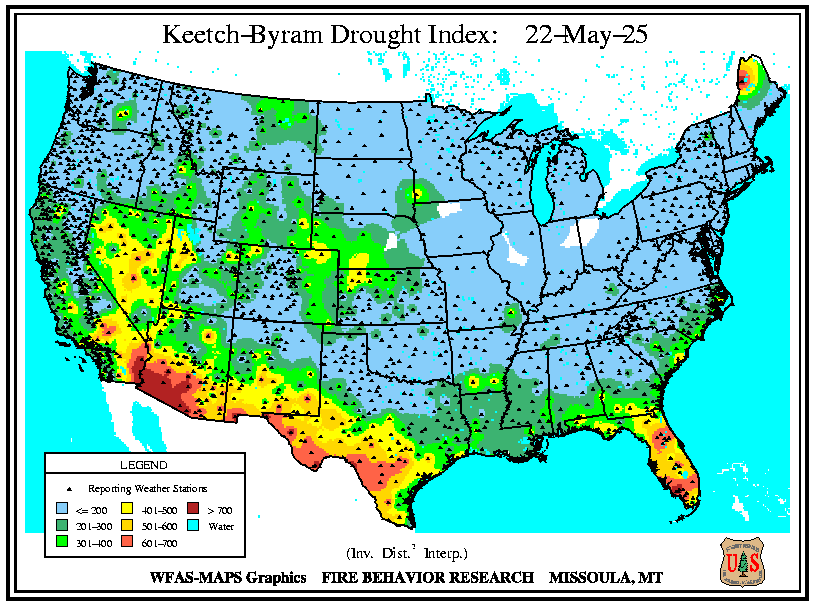

In [ ]:
KBDI.sel(time=(KBDI.time.dt.month==5)&(KBDI.time.dt.day==22))

values look reasonable

## A little more quantification

What percent of the days fall into each category of KBDI?

- KBDI = 0 - 200: Soil moisture and large class fuel moistures are high and do not contribute much to fire intensity. Typical of spring dormant season following winter precipitation.
- KBDI = 200 - 400: Typical of late spring, early growing season. Lower litter and duff layers are drying and beginning to contribute to fire intensity.
- KBDI = 400 - 600: Typical of late summer, early fall. Lower litter and duff layers actively contribute to fire intensity and will burn actively.
- KBDI = 600 - 800: Often associated with more severe drought with increased wildfire occurrence. Intense, deep burning fires with significant downwind spotting can be expected. Live fuels can also be expected to burn actively at these levels.

In [ ]:
# initialize
KBDIcat = KBDI.copy()
KBDIcat[:]=np.nan

KBDIcat = xr.where(KBDI>=200,1,KBDIcat)
KBDIcat = xr.where((201<=KBDI)&(KBDI<=400),2,KBDIcat)
KBDIcat = xr.where((401<=KBDI)&(KBDI<=600),3,KBDIcat)
KBDIcat = xr.where((601<=KBDI)&(KBDI<=800),4,KBDIcat)

ndays = np.isfinite(KBDIcat).sum().item()

for c in [1,2,3,4]:
    percent_cat = round((KBDIcat==c).sum().item()/ndays*100,2)
    print(f'{percent_cat}% of days in the timeseries are KBDI category {c}')

values look reasonable